In [3]:
!python -V

Python 3.9.12


In [4]:
import pandas as pd

In [5]:
!pip install pyarrow

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

# Q1. Downloading the data

Download the data for January and February 2023.

In [8]:
df_train = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_val = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')


In [9]:
df_train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


Read the data for January. How many columns are there?

=> 19 columns

# Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

In [10]:
df_train['duration'] = df_train['tpep_dropoff_datetime'] - df_train['tpep_pickup_datetime']
df_val['duration'] = df_val['tpep_dropoff_datetime'] - df_val['tpep_pickup_datetime']

In [11]:
df_train['duration'] = df_train.duration.apply(lambda td: td.total_seconds()/60)

df_val['duration'] = df_val.duration.apply(lambda td: td.total_seconds()/60)

In [12]:
df_train.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

What's the standard deviation of the trips duration in January?

=> 42.59

# Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [13]:
((df_train.duration >= 1) & (df_train.duration <= 60)).mean()
((df_val.duration >= 1) & (df_val.duration <= 60)).mean()

0.9800944077722545

In [14]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

In [15]:
df_train

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [16]:
initial_records = 3066766
final_records = 3009173
print((final_records*100)/initial_records)
#dropped_records = 3066766 - 3009173


98.1220282212598


What fraction of the records left after you dropped the outliers?

=> 98%

# Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

i. Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)

ii. Fit a dictionary vectorizer

iii. Get a feature matrix from it

In [17]:
categorical = ['PULocationID', 'DOLocationID']

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

/tmp/ipykernel_35787/2536479654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[categorical] = df_train[categorical].astype(str)


In [18]:
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [20]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

What's the dimensionality of this matrix (number of columns)?

=> 515

# Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

i. Train a plain linear regression model with default parameters, where duration is the response variable

ii. Calculate the RMSE of the model on the training data

In [21]:
target = 'duration'
y_train = df_train[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lr.predict(X_train)

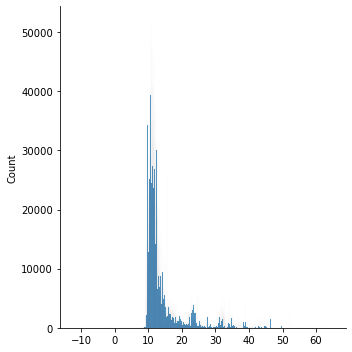

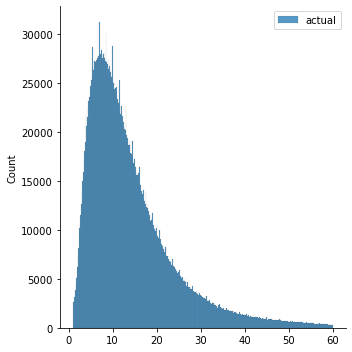

In [24]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [25]:
mean_squared_error(y_train, y_pred, squared=False)

7.6492610279057605

What's the RMSE on train?

=> 7.64

# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

In [40]:
#dv = DictVectorizer()
X_val = dv.transform(val_dicts)

In [41]:
X_val

<2855951x514 sparse matrix of type '<class 'numpy.float64'>'
	with 5711902 stored elements in Compressed Sparse Row format>

In [42]:
target = 'duration'
y_val = df_val[target].values

In [43]:
lr = LinearRegression()
lr.fit(X_val, y_val)

LinearRegression()

In [44]:
y_pred = lr.predict(X_val)

In [45]:
y_pred

array([11.51841385, 49.48218154, 15.72472075, ..., 14.08188968,
       11.26350305, 13.40797538])

In [46]:
mean_squared_error(y_val, y_pred, squared=False)

7.778947591715993

What's the RMSE on validation?

=> 7.81